## Imports and Setup
Updated with NOISE_STD, VGG_WEIGHT, and library imports. Checks for GPU availability

In [1]:
import os
import json
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
# FIXED: Updated AMP imports
from torch.amp import autocast, GradScaler 
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm  # FIXED: Progress bar
import matplotlib.pyplot as plt

# Set seeds
torch.manual_seed(42)
np.random.seed(42)

# --- Configuration ---
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 100
PHYSICS_WEIGHT = 0.1
VGG_WEIGHT = 0.1
OUTPUT_DIR = "/kaggle/working"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")

# Dataset Discovery
search_path = "/kaggle/input/**/*.pt"
pt_files = glob.glob(search_path, recursive=True)
if not pt_files:
    raise FileNotFoundError("❌ Dataset not found!")
DATA_FILE = pt_files[0]
DATA_DIR = os.path.dirname(DATA_FILE)
STATS_FILE = os.path.join(DATA_DIR, "normalization_stats.json")

🚀 Device: cuda


## Dataset Class 
Added ```noise_std``` parameter for Sim-to-Real gap augmentation.

In [2]:
class FluidLoader(Dataset):
    def __init__(self, pt_file, stats_file, target_res=256):
        print(f"⏳ Loading data map...")
        try:
            data = torch.load(pt_file, map_location='cpu', mmap=True)
        except:
            data = torch.load(pt_file, map_location='cpu')
            
        self.inputs = data['inputs']
        self.targets = data['targets']
        self.target_res = target_res
        
        # FIXED: Check resolution once at startup
        # We check the first sample to determine if upscaling is needed
        sample_h = self.inputs.shape[-1]
        self.needs_upscale = (sample_h != target_res)
        
        # Load K
        if 'K' in data:
            self.K = float(data['K'])
        elif os.path.exists(stats_file):
            with open(stats_file, 'r') as f:
                stats = json.load(f)
            self.K = float(stats['scaling_factor'])
        else:
            self.K = 1.0
            
        print(f"✅ Loaded {len(self.inputs)} samples. Upscaling: {self.needs_upscale}")

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # FIXED: Removed .clone() (F.interpolate creates a new tensor anyway)
        lr = self.inputs[idx] 
        hr = self.targets[idx]
        
        # FIXED: Use pre-calculated flag instead of checking shape every time
        if self.needs_upscale:
            lr = F.interpolate(
                lr.unsqueeze(0), 
                size=(self.target_res, self.target_res), 
                mode='bilinear', 
                align_corners=False
            ).squeeze(0)
            
        return lr, hr

## Model Architecture (ResUNet)

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class ResUNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=2, features=[64, 128, 256, 512]):
        super(ResUNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder
        self.input_conv = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(features[0]),
            nn.ReLU(inplace=True)
        )
        input_feat = features[0]
        for feature in features:
            self.encoder.append(ResidualBlock(input_feat, feature))
            input_feat = feature

        # Bottleneck
        self.bottleneck = ResidualBlock(features[-1], features[-1] * 2)

        # Decoder
        self.upconvs = nn.ModuleList()
        self.decoder = nn.ModuleList()
        features = features[::-1]
        for feature in features:
            self.upconvs.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(ResidualBlock(feature * 2, feature))

        # Output
        self.final_conv = nn.Conv2d(features[-1], out_channels, kernel_size=1)
        
    def forward(self, x):
        skip_connections = []
        out = self.input_conv(x)
        
        for layer in self.encoder:
            out = layer(out)
            skip_connections.append(out)
            out = self.pool(out)
            
        out = self.bottleneck(out)
        skip_connections = skip_connections[::-1] 
        
        for idx in range(len(self.decoder)):
            out = self.upconvs[idx](out)
            skip = skip_connections[idx]
            if out.shape != skip.shape:
                out = F.interpolate(out, size=skip.shape[2:], mode='bilinear', align_corners=False)
            concat_skip = torch.cat((skip, out), dim=1)
            out = self.decoder[idx](concat_skip)
            
        out = self.final_conv(out)
        
        return out

## Loss Functions ( VGG, Physics Informed)

In [4]:
class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(vgg.features.children())[:35]).eval()
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
            
        # FIXED: ImageNet Normalization constants as buffers
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target):
        # 1. Expand 2 channel -> 3 channel (Append Zero channel)
        # Using pad is more efficient than creating zeros and catting
        # Pad format: (left, right, top, bottom, front, back) for last 3 dims? 
        # F.pad for 4D input (B, C, H, W) pads starting from last dim.
        # We want to pad Channel dim. F.pad tuple is (W_l, W_r, H_t, H_b, C_f, C_b)?? No.
        # Simple concat is safer for clarity, but lets optimize allocation.
        
        b, c, h, w = input.shape
        # Create zero channel ONCE per batch if size constant? 
        # Just stick to cat for safety but ensure device match.
        zeros = torch.zeros(b, 1, h, w, device=input.device, dtype=input.dtype)
        
        input_3c = torch.cat([input, zeros], dim=1)
        target_3c = torch.cat([target, zeros], dim=1)
        
        # 2. FIXED: Normalize to ImageNet stats
        # VGG expects [0, 1] usually, but our data is normalized by K.
        # We assume input is roughly in reasonable range, but centering helps.
        input_norm = (input_3c - self.mean) / self.std
        target_norm = (target_3c - self.mean) / self.std
        
        input_features = self.feature_extractor(input_norm)
        target_features = self.feature_extractor(target_norm)
        return F.mse_loss(input_features, target_features)

class DivergenceLoss(nn.Module):
    def __init__(self):
        super(DivergenceLoss, self).__init__()

    def forward(self, output, scaling_factor):
        u = output[:, 0, :, :] * scaling_factor
        v = output[:, 1, :, :] * scaling_factor
        du_dx = u[:, :, 1:] - u[:, :, :-1]
        dv_dy = v[:, 1:, :] - v[:, :-1, :]
        return torch.mean((du_dx[:, :-1, :] + dv_dy[:, :, :-1])**2)

## Training Loop

In [5]:
def train(use_physics=False):
    # 1. Data
    dataset = FluidLoader(DATA_FILE, STATS_FILE)
    train_sz = int(0.8 * len(dataset))
    val_sz = len(dataset) - train_sz
    train_ds, val_ds = random_split(dataset, [train_sz, val_sz], generator=torch.Generator().manual_seed(42))
    
    # Num_workers=2 is usually safe on Kaggle
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # 2. Setup
    model = ResUNet(in_channels=6, out_channels=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # FIXED: Added Scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    # FIXED: Updated Scaler init
    scaler = GradScaler('cuda') 
    
    mse_fn = nn.MSELoss()
    vgg_fn = VGGLoss().to(device)
    div_fn = DivergenceLoss().to(device)
    K = dataset.K
    
    mode_name = "PINN" if use_physics else "Baseline"
    print(f"\n🚀 Starting {mode_name} Training...")
    
    hist = {'train': [], 'val': [], 'lr': []}
    best_val_loss = float('inf')
    patience = 7
    counter = 0

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        
        # FIXED: TQDM Progress Bar
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
        
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad(set_to_none=True) # set_to_none is slightly faster
            
            with autocast('cuda'): 
                pred = model(x)
                
                # Losses
                loss = mse_fn(pred, y)
                loss += VGG_WEIGHT * vgg_fn(pred, y)
                
                if use_physics:
                    # FIXED: Only Divergence
                    loss += PHYSICS_WEIGHT * div_fn(pred, K)
            
            scaler.scale(loss).backward()
            
            # FIXED: Gradient Clipping (Unscale before clipping)
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())
            
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                with autocast('cuda'):
                    pred = model(x)
                    val_loss += mse_fn(pred, y).item()
        
        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        
        # Step Scheduler
        scheduler.step(avg_val)
        current_lr = optimizer.param_groups[0]['lr']
        
        hist['train'].append(avg_train)
        hist['val'].append(avg_val)
        hist['lr'].append(current_lr)
        
        print(f"Epoch {epoch+1} | Train: {avg_train:.6f} | Val: {avg_val:.6f} | LR: {current_lr:.2e}")
        
        # FIXED: Better Checkpointing
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val,
        }
        
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            counter = 0
            torch.save(checkpoint, f"{OUTPUT_DIR}/{mode_name}_best.pth")
            print("  --> New Best Model Saved!")
        else:
            counter += 1
            if counter >= patience:
                print("🛑 Early Stopping triggered.")
                break
                
    # FIXED: Plotting improvements
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist['train'], label='Train')
    plt.plot(hist['val'], label='Val')
    plt.title(f'{mode_name} Loss')
    plt.yscale('log') # Log scale is often better for loss
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(hist['lr'], color='orange')
    plt.title('Learning Rate')
    plt.grid(True, alpha=0.3)
    
    plt.savefig(f"{OUTPUT_DIR}/{mode_name}_history.png")
    plt.show()
    
    # Reload best model for return
    best_checkpoint = torch.load(f"{OUTPUT_DIR}/{mode_name}_best.pth")
    model.load_state_dict(best_checkpoint['model_state_dict'])
    
    return model, dataset

## Execute
Run this cell to start.

⏳ Loading data map...
✅ Loaded 5920 samples. Upscaling: False


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 193MB/s]



🚀 Starting Baseline Training...


Epoch 1/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 1 | Train: 0.099724 | Val: 0.005009 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 2/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 2 | Train: 0.063949 | Val: 0.004244 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 3/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3 | Train: 0.053345 | Val: 0.003522 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 4/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 4 | Train: 0.046502 | Val: 0.003313 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 5/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 5 | Train: 0.041551 | Val: 0.002948 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 6/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 6 | Train: 0.037605 | Val: 0.002775 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 7/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 7 | Train: 0.034312 | Val: 0.002582 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 8/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 8 | Train: 0.031625 | Val: 0.002539 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 9/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

     if w.is_alive(): 
           ^^ ^^^^^^^^^^^^^^^^^^^^^
^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        assert self.

Epoch 9 | Train: 0.029243 | Val: 0.002417 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 10/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 10 | Train: 0.027051 | Val: 0.002342 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 11/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 11 | Train: 0.025366 | Val: 0.002233 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 12/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 12 | Train: 0.023881 | Val: 0.002104 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 13/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 13 | Train: 0.022562 | Val: 0.002205 | LR: 1.00e-04


Epoch 14/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 14 | Train: 0.021348 | Val: 0.001978 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 15/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 15 | Train: 0.020356 | Val: 0.001965 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 16/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 16 | Train: 0.019452 | Val: 0.001890 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 17/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 17 | Train: 0.018653 | Val: 0.001897 | LR: 1.00e-04


Epoch 18/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 18 | Train: 0.017912 | Val: 0.001800 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 19/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 19 | Train: 0.017305 | Val: 0.001760 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 20/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 20 | Train: 0.016633 | Val: 0.001705 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 21/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 21 | Train: 0.015969 | Val: 0.001722 | LR: 1.00e-04


Epoch 22/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 22 | Train: 0.015594 | Val: 0.001678 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 23/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 23 | Train: 0.015019 | Val: 0.001699 | LR: 1.00e-04


Epoch 24/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 24 | Train: 0.014631 | Val: 0.001618 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 25/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 25 | Train: 0.014158 | Val: 0.001577 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 26/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 26 | Train: 0.013772 | Val: 0.001605 | LR: 1.00e-04


Epoch 27/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 27 | Train: 0.013485 | Val: 0.001533 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 28/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 28 | Train: 0.013088 | Val: 0.001490 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 29/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 29 | Train: 0.012800 | Val: 0.001503 | LR: 1.00e-04


Epoch 30/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 30 | Train: 0.012511 | Val: 0.001422 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 31/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 31 | Train: 0.012245 | Val: 0.001469 | LR: 1.00e-04


Epoch 32/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 32 | Train: 0.011928 | Val: 0.001415 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 33/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 33 | Train: 0.011630 | Val: 0.001423 | LR: 1.00e-04


Epoch 34/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 34 | Train: 0.011512 | Val: 0.001428 | LR: 1.00e-04


Epoch 35/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 35 | Train: 0.011191 | Val: 0.001371 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 36/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 36 | Train: 0.010942 | Val: 0.001365 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 37/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive(): 
            ^ ^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._par

Epoch 37 | Train: 0.010730 | Val: 0.001346 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 38/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 38 | Train: 0.010535 | Val: 0.001317 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 39/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 39 | Train: 0.010423 | Val: 0.001325 | LR: 1.00e-04


Epoch 40/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 40 | Train: 0.010218 | Val: 0.001326 | LR: 1.00e-04


Epoch 41/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 41 | Train: 0.010020 | Val: 0.001292 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 42/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 42 | Train: 0.009857 | Val: 0.001284 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 43/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 43 | Train: 0.009667 | Val: 0.001273 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 44/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 44 | Train: 0.009536 | Val: 0.001310 | LR: 1.00e-04


Epoch 45/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 45 | Train: 0.009407 | Val: 0.001239 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 46/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 46 | Train: 0.009284 | Val: 0.001251 | LR: 1.00e-04


Epoch 47/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 47 | Train: 0.009128 | Val: 0.001234 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 48/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 48 | Train: 0.008983 | Val: 0.001215 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 49/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 49 | Train: 0.008886 | Val: 0.001208 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 50/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 50 | Train: 0.008757 | Val: 0.001187 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 51/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 51 | Train: 0.008639 | Val: 0.001165 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 52/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 52 | Train: 0.008549 | Val: 0.001182 | LR: 1.00e-04


Epoch 53/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 53 | Train: 0.008387 | Val: 0.001155 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 54/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 54 | Train: 0.008262 | Val: 0.001157 | LR: 1.00e-04


Epoch 55/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 55 | Train: 0.008199 | Val: 0.001161 | LR: 1.00e-04


Epoch 56/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 56 | Train: 0.008102 | Val: 0.001137 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 57/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 57 | Train: 0.007991 | Val: 0.001128 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 58/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 58 | Train: 0.007888 | Val: 0.001109 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 59/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 59 | Train: 0.007813 | Val: 0.001134 | LR: 1.00e-04


Epoch 60/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 60 | Train: 0.007697 | Val: 0.001119 | LR: 1.00e-04


Epoch 61/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 61 | Train: 0.007624 | Val: 0.001103 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 62/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 62 | Train: 0.007536 | Val: 0.001080 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 63/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 63 | Train: 0.007462 | Val: 0.001098 | LR: 1.00e-04


Epoch 64/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 64 | Train: 0.007405 | Val: 0.001137 | LR: 1.00e-04


Epoch 65/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 65 | Train: 0.007289 | Val: 0.001091 | LR: 1.00e-04


Epoch 66/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 66 | Train: 0.007209 | Val: 0.001077 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 67/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

             ^^ ^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^

   File "/usr/lib/pytho

Epoch 67 | Train: 0.007101 | Val: 0.001053 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 68/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 68 | Train: 0.007147 | Val: 0.001071 | LR: 1.00e-04


Epoch 69/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 69 | Train: 0.007037 | Val: 0.001073 | LR: 1.00e-04


Epoch 70/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 70 | Train: 0.006910 | Val: 0.001061 | LR: 1.00e-04


Epoch 71/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 71 | Train: 0.006896 | Val: 0.001062 | LR: 1.00e-04


Epoch 72/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 72 | Train: 0.006812 | Val: 0.001039 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 73/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 73 | Train: 0.006705 | Val: 0.001013 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 74/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 74 | Train: 0.006692 | Val: 0.001025 | LR: 1.00e-04


Epoch 75/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 75 | Train: 0.006638 | Val: 0.001024 | LR: 1.00e-04


Epoch 76/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 76 | Train: 0.006548 | Val: 0.001014 | LR: 1.00e-04


Epoch 77/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 77 | Train: 0.006504 | Val: 0.001000 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 78/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 78 | Train: 0.006465 | Val: 0.001003 | LR: 1.00e-04


Epoch 79/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 79 | Train: 0.006412 | Val: 0.001014 | LR: 1.00e-04


Epoch 80/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 80 | Train: 0.006314 | Val: 0.000999 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 81/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 81 | Train: 0.006270 | Val: 0.000984 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 82/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 82 | Train: 0.006278 | Val: 0.001001 | LR: 1.00e-04


Epoch 83/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 83 | Train: 0.006178 | Val: 0.000989 | LR: 1.00e-04


Epoch 84/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 84 | Train: 0.006105 | Val: 0.000979 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 85/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 85 | Train: 0.006086 | Val: 0.000984 | LR: 1.00e-04


Epoch 86/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 86 | Train: 0.006034 | Val: 0.000957 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 87/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 87 | Train: 0.006000 | Val: 0.000979 | LR: 1.00e-04


Epoch 88/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 88 | Train: 0.005949 | Val: 0.000951 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 89/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 89 | Train: 0.005875 | Val: 0.000989 | LR: 1.00e-04


Epoch 90/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 90 | Train: 0.005876 | Val: 0.000955 | LR: 1.00e-04


Epoch 91/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 91 | Train: 0.005814 | Val: 0.000964 | LR: 1.00e-04


Epoch 92/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 92 | Train: 0.005747 | Val: 0.000947 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 93/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7dcf4e329440>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     if w.is_alive(): 
          ^^ ^^ ^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^^

   File "/usr/lib/pytho

Epoch 93 | Train: 0.005738 | Val: 0.000956 | LR: 1.00e-04


Epoch 94/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 94 | Train: 0.005712 | Val: 0.000954 | LR: 1.00e-04


Epoch 95/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 95 | Train: 0.005634 | Val: 0.000936 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 96/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 96 | Train: 0.005614 | Val: 0.000964 | LR: 1.00e-04


Epoch 97/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 97 | Train: 0.005577 | Val: 0.000953 | LR: 1.00e-04


Epoch 98/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 98 | Train: 0.005560 | Val: 0.000947 | LR: 1.00e-04


Epoch 99/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 99 | Train: 0.005496 | Val: 0.000931 | LR: 1.00e-04
  --> New Best Model Saved!


Epoch 100/100:   0%|          | 0/1184 [00:00<?, ?it/s]

Epoch 100 | Train: 0.005438 | Val: 0.000955 | LR: 1.00e-04


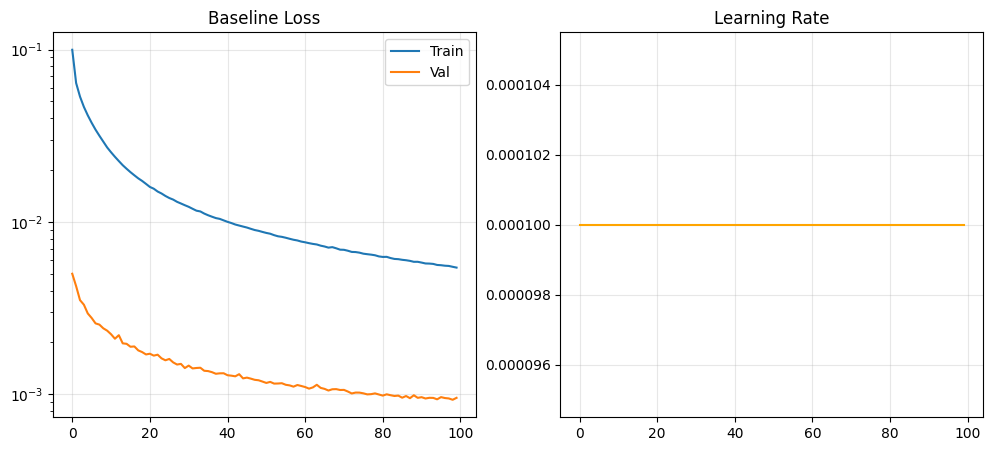

In [6]:
# --- Run Baseline Training ---
# 1. Train the model (Physics is OFF for baseline)
model, dataset = train(use_physics=False)

# --- (Optional) Run Physics-Informed Training ---
# Uncomment the line below to train with Physics Loss enabled
# model_pinn, dataset = train(use_physics=True)